<a href="https://colab.research.google.com/github/SangHee33/Sanghee2/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_3%EC%9E%A5_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

p. 127~154

In [2]:
# MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

딕셔너리 구조
- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


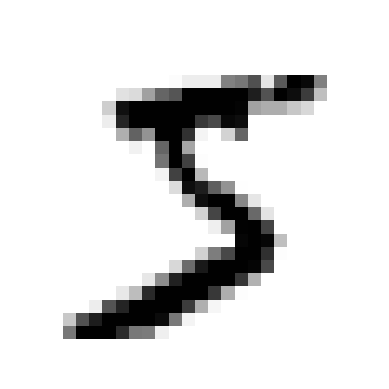

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# y를 정수로 변환
import numpy as np
import pandas as pd

y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

SGDClassifier 클래스를 사용해 확률적 경사 하강법 분류기 사용

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정
## 3.3.1 교차 검증을 사용한 정확도 측정

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


StartifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행

cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 검증을 사용해 SGDClassifier 모델을 평가

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 생성

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
# 모델 정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

불균형한 데이터셋을 다룰 때 정확도를 분류기의 성능 측정 지표로 선호하지 않음

## 3.3.2 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법

5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차행렬의 5행 3열

cross_val_predict() 함수 사용

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 오차행렬의 행은 실제 클래스, 열은 예측한 클래스
- 위 행렬의 첫 번째 행은 '5 아님'(음성 클래스)이고 53,057개(진짜 음성)를 '5 아님'으로 정확하게 분류

In [17]:
y_train_perfect_predicts = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predicts)

array([[54579,     0],
       [    0,  5421]])

 분류기의 정밀도 = 양성 예측의 정확도 = TP/(TP+FP)
 재현율 = 정확하게 감지한 양성 샘플의 비율 = 민감도 = 진짜 양성 비율 = TP/(TP+FN)

## 3.3.3 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

F1 점수 = 조화 평균 = 2/(1/정밀도+1/재현율) = TP/(TP+(FN+FP)/2)

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 f1 점수가 높지만 항상 좋은 것은 아님
- 정밀도와 재현율은 반비례 관계 = 정밀도/재현율 트레이드오프

## 정밀도/재현율 트레이드오프

- SGDClassifier는 결정 함수를 사용하여 각 샘플의 점수를 계산
- 점수가 임곗값보다 크면 양성 클래스에 할당
- 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수 확인 가능

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
# 적절한 임곗값 정하기
# 훈련 세트에 있는 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [25]:
# 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

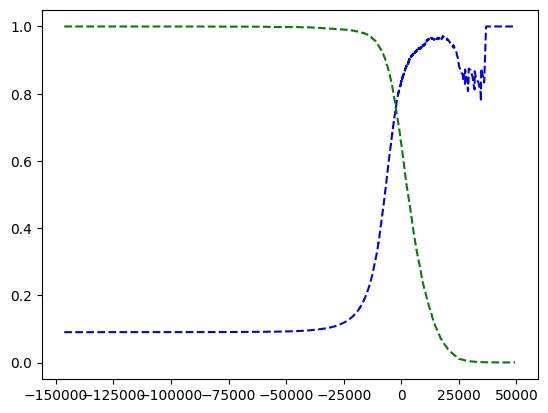

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g--", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

정밀도 하강점 직전을 정밀도/재현율 트레이드오프로 선택

In [27]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선
- 수신기 조작 특성(ROC) 곡선 = 진짜 양성 비율 / 거짓 양성 비율 = 1-진짜 음성 비율(특이도)

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

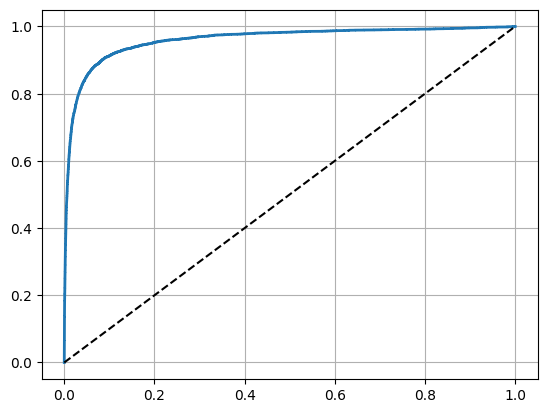

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선
  plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

- 곡선 아래의 면적(AUC)
- 완벽한 분류기의 AUC는 1

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

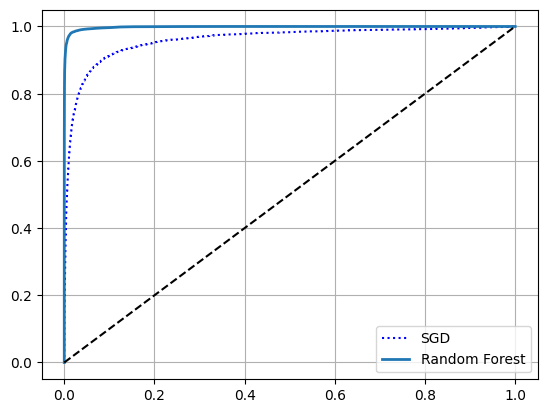

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

# 3.4 다중 분류
- 다중 분류기(다항 분류기)는 둘 이상의 클래스 구별
- OvR(OvA) 전략 : 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
- OvO 전략 : 각 숫자의 조합마다 이진 분류기를 훈련

In [38]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
# 가장 높은 값이 5에 해당하는 값
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
svm_clf.classes_[5]

5

In [43]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
len(ovr_clf.estimators_)

10

In [46]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [47]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# 3.5 에러 분석

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

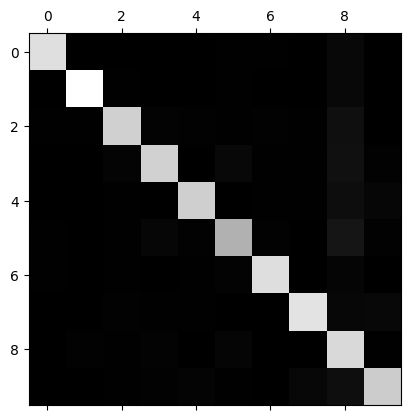

In [51]:
# 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

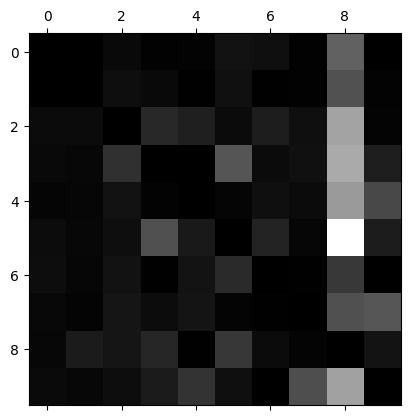

In [53]:
# 주대각선을 0으로 채워서 그래프 생성
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

실제 8이 적절히 8로 분류되었음
3과 5가 많이 혼동되고 있음

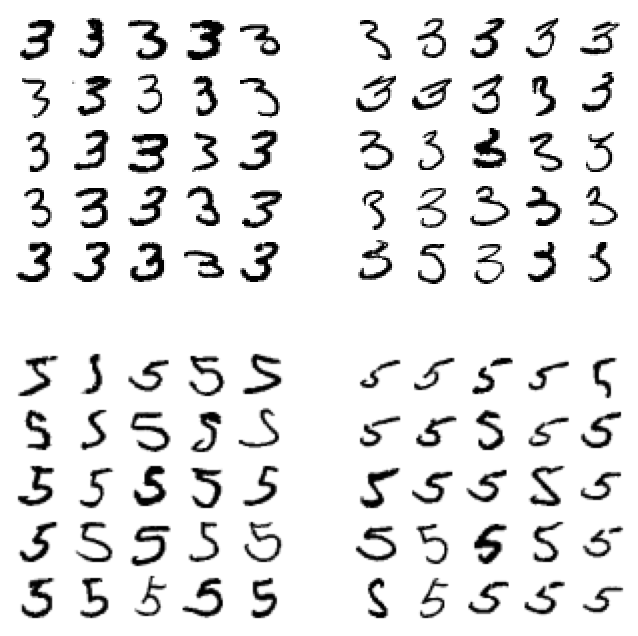

In [55]:
# 3과 5의 샘플 그리기
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

선형 모델인 SGDClassifier을 사용하여 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산하기 때문에 쉽게 혼동

-> 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하여 에러 줄이기

# 3.6 다중 레이블 분류
다줄 레이블 분류 : 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [56]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") # 클래스의 지지도를 가중치로 주려면 average="weighted"로 설정

0.976410265560605

# 3.7 다중 출력 분류
다중 출력 다중 클래스 분류 = 다중 출력 분류

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [63]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

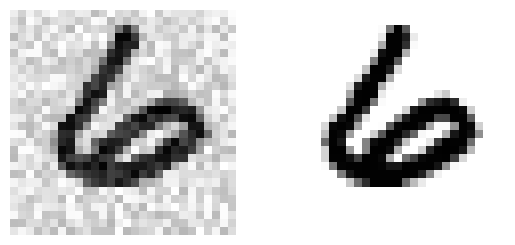

In [64]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

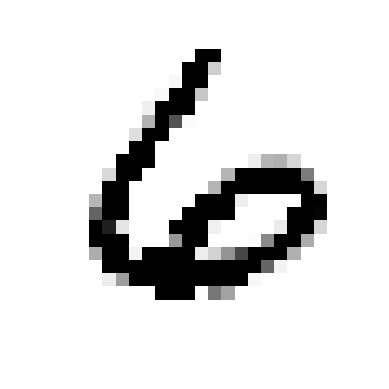

In [65]:
# 분류기를 훈련시켜 이미지를 깨끗하게 생성
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)